In [1]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7fae911bd5d0>)

In [2]:
import re

f = open("train.txt", "r")
tagged_sentences = []
sentence = []

for line in f:
  if len(line) == 0 or line.startswith("-DOCSTART") or line[0] == '\n':
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ')
  splits[-1] = re.sub(r'\n', '', splits[-1])
  word  = splits[0].lower()
  sentence.append([word, splits[-1]])

In [3]:
print("전체 샘플 수 : ", len(tagged_sentences))

전체 샘플 수 :  14041


In [4]:
print("첫 번째 샘플 : ", tagged_sentences[0])

첫 번째 샘플 :  [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [5]:
sentences, ner_tag = [], []

for tagged_sentence in tagged_sentences:
  sentence, ner_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tag.append(list(ner_info))

In [6]:
print(sentences[0])
print(ner_tag[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


가장 긴 문장 길이 : 113
평균 문장 길이 : 14.501887


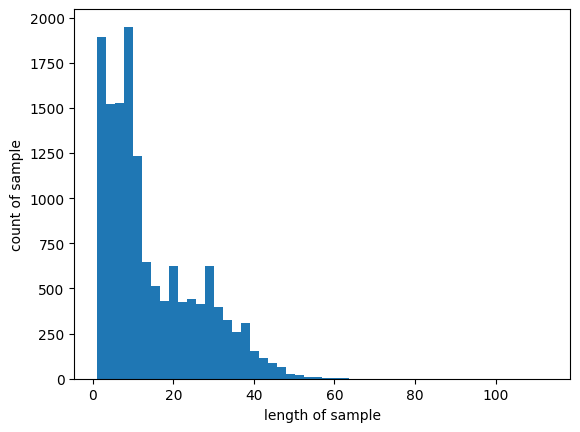

In [7]:
import matplotlib.pyplot as plt

print("가장 긴 문장 길이 : %d" % max(len(sentence) for sentence in sentences))
print("평균 문장 길이 : %f" %(sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel("length of sample")
plt.ylabel("count of sample")
plt.show()

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 4000

src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

ner_tokenizer = Tokenizer()
ner_tokenizer.fit_on_texts(ner_tag)

In [14]:
ner_tokenizer.word_index

{'o': 1,
 'b-loc': 2,
 'b-per': 3,
 'b-org': 4,
 'i-per': 5,
 'i-org': 6,
 'b-misc': 7,
 'i-loc': 8,
 'i-misc': 9}

In [17]:
tag_size = len(ner_tokenizer.word_index) + 1

print("단어 사전 : {}".format(vocab_size))
print("태깅 개수 : {}".format(tag_size))

단어 사전 : 4000
태깅 개수 : 10


In [19]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = ner_tokenizer.texts_to_sequences(ner_tag)

In [21]:
print(x_data[0])
print(y_data[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [18]:
index_to_word = src_tokenizer.index_word
index_to_ner = ner_tokenizer.index_word

In [23]:
decoded = []

for word in x_data[0]:
  decoded.append(index_to_word[word])

In [26]:
print("원래 문장 : ", sentences[0])
print("oov 처리된 문장 :", decoded)

원래 문장 :  ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
oov 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 70

x_data = pad_sequences(x_data, maxlen=max_len, padding='post')
y_data = pad_sequences(y_data, maxlen=max_len, padding='post')

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [32]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [33]:
print("훈련 데이터 문장 구조 : {}".format(x_train.shape))
print("검증 데이터 문장 구조 : {}".format(x_test.shape))
print("훈련 레이블 구조 : {}".format(y_train.shape))
print("검증 레이블 구조 : {}".format(y_test.shape))

훈련 데이터 문장 구조 : (11232, 70)
검증 데이터 문장 구조 : (2809, 70)
훈련 레이블 구조 : (11232, 70, 10)
검증 레이블 구조 : (2809, 70, 10)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, input_length=max_len))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [41]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=8, validation_data=(x_test, y_test))

Epoch 1/8
88/88 [==============================] - 72s 710ms/step - loss: 0.0953 - accuracy: 0.9717 - val_loss: 0.1693 - val_accuracy: 0.9552
Epoch 2/8
88/88 [==============================] - 59s 665ms/step - loss: 0.0827 - accuracy: 0.9754 - val_loss: 0.1649 - val_accuracy: 0.9548
Epoch 3/8
88/88 [==============================] - 65s 738ms/step - loss: 0.0737 - accuracy: 0.9779 - val_loss: 0.1708 - val_accuracy: 0.9545
Epoch 4/8
88/88 [==============================] - 59s 675ms/step - loss: 0.0654 - accuracy: 0.9804 - val_loss: 0.1842 - val_accuracy: 0.9549
Epoch 5/8
88/88 [==============================] - 60s 681ms/step - loss: 0.0575 - accuracy: 0.9832 - val_loss: 0.1853 - val_accuracy: 0.9529
Epoch 6/8
88/88 [==============================] - 64s 734ms/step - loss: 0.0540 - accuracy: 0.9841 - val_loss: 0.1888 - val_accuracy: 0.9533
Epoch 7/8
88/88 [==============================] - 66s 752ms/step - loss: 0.0473 - accuracy: 0.9859 - val_loss: 0.1992 - val_accuracy: 0.9529
Epoch 

In [44]:
print("모델 검증 정확도 %.4f" % (model.evaluate(x_test, y_test)[1]))

88/88 [==============================] - 7s 83ms/step - loss: 0.1995 - accuracy: 0.9532
모델 검증 정확도 0.9532


In [46]:
import numpy as np

i = 10

y_predicted = model.predict(np.array([x_test[i]]))

y_predicted = np.argmax(y_predicted, axis=-1)

labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35*"-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
  if word != 0:
    print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

1/1 [==============================] - 0s 31ms/step
단어             |실제값  |예측값
-----------------------------------
in               : O       O
san              : B-LOC   B-LOC
francisco        : I-LOC   I-LOC
,                : O       O
mike             : B-PER   B-PER
williams         : I-PER   I-PER
allowed          : O       O
two              : O       O
runs             : O       O
in               : O       O
OOV              : O       O
innings          : O       O
and              : O       O
OOV              : B-PER   B-PER
OOV              : I-PER   I-PER
and              : O       O
OOV              : B-PER   B-PER
OOV              : I-PER   I-PER
had              : O       O
rbi              : B-MISC  B-MISC
hits             : O       O
in               : O       O
the              : O       O
first            : O       O
inning           : O       O
as               : O       O
the              : O       O
philadelphia     : B-ORG   B-ORG
phillies         : I-ORG   I-ORG


[노션 내용 정리](https://www.notion.so/BIO-7b75e2e3a6314235bf4c97d506e73359)

